# Programação para Ciência de Dados - Equipe 7

## Alunos:
* Francisco Marcelo Mendes Damasceno (fmmd.cid20@uea.edu.br)
* Lucas Pereira Reis (lpr.cid20@uea.edu.br)
* Marcos Wenneton Vieira de Araujo (mwvda.cid20@uea.edu.br)

## Visão Geral do Conjunto de Dados

In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import time
from datetime import datetime, date, timedelta
import statistics

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
%matplotlib inline
sns.set_theme();

from google.colab import files

In [ ]:
df = pd.read_json('http://tiagodemelo.info/datasets/dataset-v2.dat', lines=True)

In [ ]:
df.sample(5)

title  ...                                       itemReviewed
7026                           Itapuã  ...  {'name': 'Churrascaria Laco Gaucho', 'address'...
36352                         Gostoso  ...  {'name': 'Axe Cozinha Tipica', 'address': {'st...
8319                         Mto bom!  ...  {'name': 'Monjardim Costelaria e Botequim', 'a...
27916  Uma delícia em pleno aeroporto  ...  {'name': 'Vivendas Do Camarao', 'address': {'s...
73261               Vista Excepcional  ...  {'name': 'Skye Bar & Restaurante', 'address': ...

[5 rows x 12 columns]

### Observando os atributos dos dados

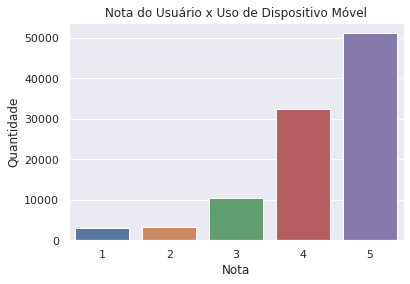

In [ ]:
g = sns.countplot(x="ratingValue", data=df);
g.set(xlabel='Nota', ylabel='Quantidade')
plt.title("Nota do Usuário x Uso de Dispositivo Móvel")
plt.show()

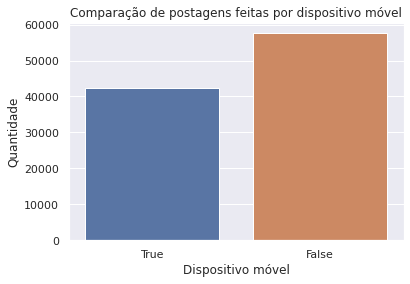

In [ ]:
g = sns.countplot(x="mobileDevice", data=df)
g.set(xlabel='Dispositivo móvel', ylabel='Quantidade')
plt.title("Comparação de postagens feitas por dispositivo móvel")
plt.show()

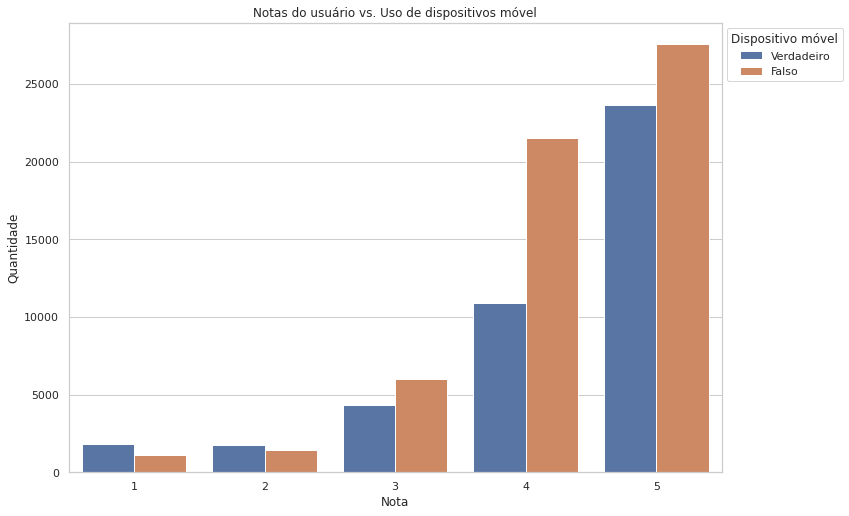

In [ ]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
g = sns.countplot(x="ratingValue", hue="mobileDevice",data=df)
legend_labels, _= g.get_legend_handles_labels()
g.legend(legend_labels, ['Verdadeiro', 'Falso'], 
          bbox_to_anchor=(1,1), 
          title='Dispositivo móvel')
g.set(xlabel='Nota', ylabel='Quantidade')
plt.title("Notas do usuário vs. Uso de dispositivos móvel")
plt.show()

Observando o gráfico acima, percebe-se que quando um usuário publica uma nota muito baixa, a tendência é que essa publicação seja feita através de um dispositivo móvel. Isso pode ser explicado, talvez, pela urgência do cliente de fazer uma reclamação ao se deparar com uma situação incoveniente.

### Extensão dos comentários

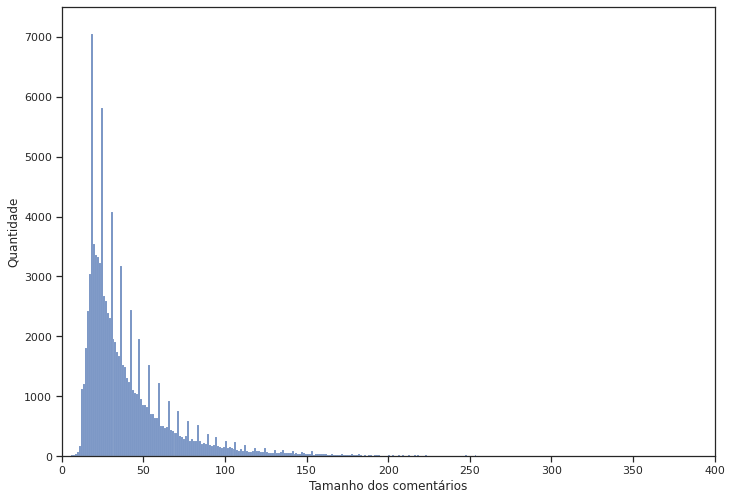

In [ ]:
X = df['reviewBody'].astype('str')
length_dist = [len(x.split(" ")) for x in X]
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
g = sns.histplot(data=length_dist, ax=ax)
g.set(ylim=(0, 7500), xlim=(0,400), xlabel='Tamanho dos comentários', ylabel='Quantidade')
plt.show()

In [ ]:
print("Média da quantidade de caracteres nos comentários: " , round(statistics.mean(length_dist),2))
print("Comentário de maior tamanho: ", max(length_dist))
print("Comentário de menor tamanho: ", min(length_dist))

Média da quantidade de caracteres nos comentários:  42.29
Comentário de maior tamanho:  1022
Comentário de menor tamanho:  1


### Palavras mais utilizadas

In [ ]:
def word_cloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

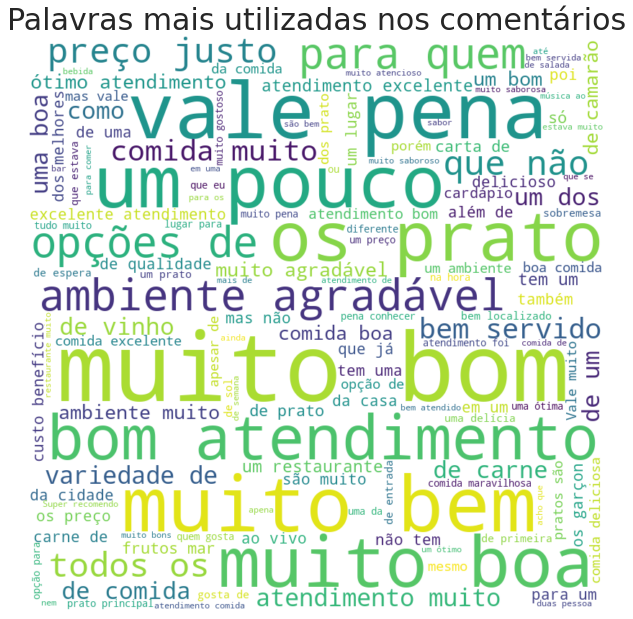

In [ ]:
word_cloud_generator(df['reviewBody'].astype(str), title="Palavras mais utilizadas nos comentários")

## Análise de Sentimento

In [ ]:
# Instalação do pacote googletrans
!pip -q install googletrans

     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 983kB 10.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 102kB 11.0MB/s 


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from googletrans import Translator
from pprint import pprint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


### Tradução do DataSet utilizando TextBlob e Googletrans

Optamos por utilizar um processo de tradução em intervalos, salvando as parciais em um arquivo `csv` no Google Drive. A razão dessa abordagem foi evitar que as traduções já realizadas fossem perdidas devido as limitações das APIs com relação a quantidade de requisições e outras eventuais interrupções por problema de conexão ou expiração do container do Colab.

Exemplo: A chamada `translate_coments(df[10000:20000],ct, method='googletrans')` vai traduzir e incrementar o dicionário temporário `ct = {'reviewId':[], 'reviewBody':[], 'reviewBody_en': []}` com a tradução dos comentários do intervalo 10000 a 20000.

Em seguida esse intervalo é salvo em arquivo da seguinte forma:

`pd.DataFrame(ct).to_csv("/content/drive/My Drive/PDC/translanted_coments_googletrans_10K_20k.csv", index=False)`

E recuperado com:

`ct = pd.read_csv('/content/drive/My Drive/PDC/translanted_coments_googletrans_10K_20k.csv').to_dict('list')`

A função `translate_text` recebe um texto e retorna a tradução através de um dos dois métodos passado como parâmetro: 'textblob' ou 'googletrans'

In [ ]:
def translate_text(text, src='auto', dest='en', method='textblob'):
  time.sleep(0.2)
  output = ''
  if method == 'textblob':
    try:
      output = TextBlob(text).translate(from_lang=src, to=dest).raw
    except NotTranslated:
      print("Não foi possível traduzir: ", text)
  elif method == 'googletrans':
    # Workaround por causa do problema - https://github.com/ssut/py-googletrans/issues/234
    translator = Translator()
    while True:
      try:
        output = translator.translate(text, src=src, dest=dest).text
        break
      except Exception as e:
        translator = Translator()
  else:
    return "'method must be either 'textblob' or 'googletrans'"
  return output

O propósito da função `translate_coments` é iterar em um DataFrame, e armazenar o resultado da tradução em um dicionário Python.

In [ ]:
def translate_coments(df, of = {}, method='textblob'):
  count = 0
  seg = 0.01 * len(df)
  for idx,row in df.iterrows():
    if count % round(seg) == 0:
      print("Processado %s%%" % (count//seg))
    count += 1
    if row.reviewId in of['reviewId']:
      print("Review %s já existe no dataset" % row.reviewId)
    else:
      try:
        of['reviewBody_en'].append(translate_text(row['reviewBody'], method=method))
        of['reviewId'].append(row['reviewId'])
        of['reviewBody'].append(row['reviewBody'])
      except Exception as e:
        print("Erro ao processar reviewId: [%s] - reviewBody: [%s] " % (row.reviewId, row.reviewBody))
        return e

Os artefatos gerados após a tradução são dois DataSets: Um com a tradução usando método do TextBlob e outro com Googletrans

In [ ]:
# Traduções TextBlob
dft = pd.read_csv("http://underlabs.org/datasets/translated_coments_textblob.csv")
# Traduções Googletrans
dfg = pd.read_csv("http://underlabs.org/datasets/translated_coments_googletrans.csv")

### Subjetividade e Polaridade


A função `get_sentences` itera em um DataFrame de comentários traduzidos e retorna um DataFrame de sentenças 4xN com as seguintes colunas:
- 'reviewId': Id do reviewBody que originou a sentença
- 'BR': Sentença em português
- 'US': Sentença em inglês
- 'SUBJECTIVITY': Score de subjetividade
- 'POLARITY': Score de polaridade

In [ ]:
# Subjetividade e Polaridade
def get_sentences(df):
  sentences_dic = {'reviewId': [],'BR':[], 'US': [], 'SUBJECTIVITY': [], 'POLARITY': []}
  df_clean = df.replace('\n','', regex=True).replace('\.\.\.','.', regex=True)
  for idx, row in df_clean.iterrows():
    try:
      coment_blob_br = TextBlob(row['reviewBody'])
      coment_blob_us = TextBlob(row['reviewBody_en'])
    except Exception as e:
      print(row)
    for sentence_br,sentence_us in zip(coment_blob_br.sentences,coment_blob_us.sentences):
      try:
        sentences_dic['reviewId'].append(row['reviewId'])
        sentences_dic['BR'].append(sentence_br.raw)
        sentences_dic['US'].append(sentence_us.raw)
        sentences_dic['SUBJECTIVITY'].append(sentence_us.subjectivity)
        sentences_dic['POLARITY'].append(sentence_us.polarity)
      except Exception as e:
        print(row)
  return pd.DataFrame(sentences_dic)

Gerando um DataFrame de sentenças a partir de um DataSet traduzido com TextBlob

In [ ]:
get_sentences(dft.sample(n=2))

reviewId  ...  POLARITY
0  469626142  ...  1.000000
1  469626142  ...  0.317500
2  460634852  ...  0.733333
3  460634852  ...  0.439333

[4 rows x 5 columns]

In [ ]:
dft_sentences = pd.read_csv("http://underlabs.org/datasets/dft_sentences.csv")

In [ ]:
dft_sentences.head()

reviewId  ...  POLARITY
0  692856288  ...  0.350000
1  229208487  ...  0.408000
2  229208487  ...  0.416667
3  679002332  ...  1.000000
4  679002332  ...  0.744444

[5 rows x 5 columns]

Após gerar o DataFrame com as sentenças e suas respectivas, é interessante analisar estes dados obtidos para enteder melhor como estas sentenças estão distribuídas no *dataset* atual.

Primeiramente será analisado a subjetividade das sentenças, como pode ser visto acima esta coluna não está categorizada em subjetiva ou objetiva/factual, trazendo na verdade um valor de 0 a 1 representando o seu nível de subjetividade. Para esta análise, será considerado 0.5 como valor intermediário para separar o conjunto de dados e poder analisá-los.

In [ ]:
subjectivity_threshold = 0.5
subjective_sentences = dft_sentences['SUBJECTIVITY'].loc[dft_sentences['SUBJECTIVITY'] > subjectivity_threshold]
factual_sentences = dft_sentences['SUBJECTIVITY'].loc[dft_sentences['SUBJECTIVITY'] <= subjectivity_threshold]

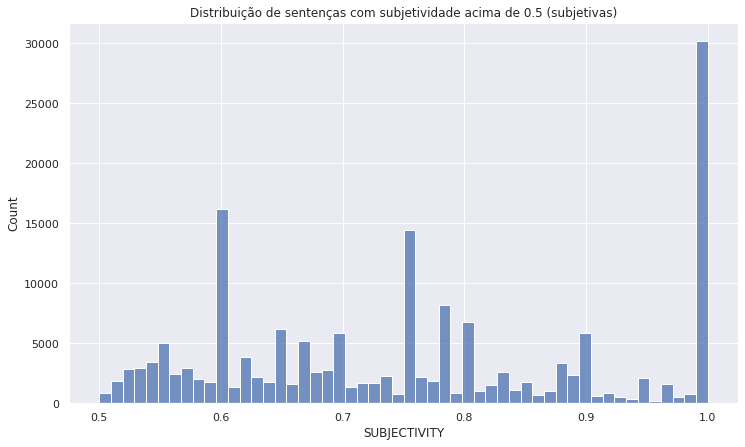

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Distribuição de sentenças com subjetividade acima de 0.5 (subjetivas)")
sns.histplot(subjective_sentences)
plt.show()

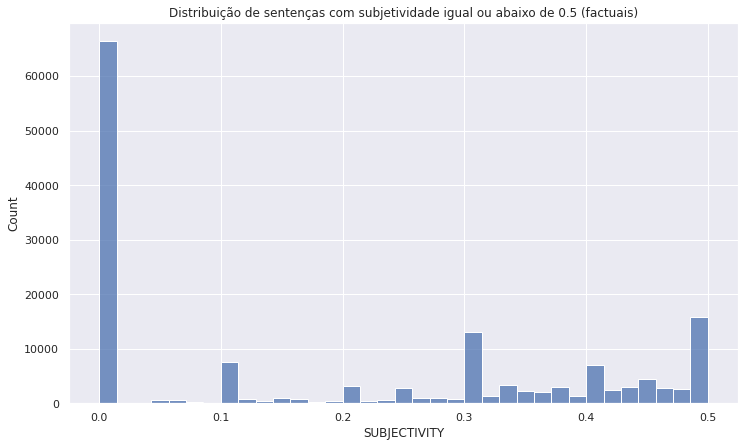

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Distribuição de sentenças com subjetividade igual ou abaixo de 0.5 (factuais)")
sns.histplot(factual_sentences)
plt.show()

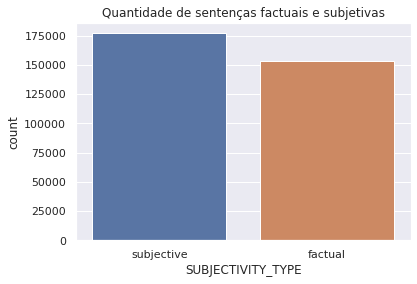

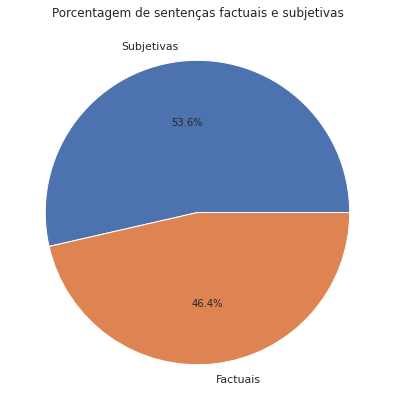

In [ ]:
df_compare = dft_sentences.copy()
df_compare['SUBJECTIVITY_TYPE'] = ['subjective' if data > subjectivity_threshold else 'factual' for data in dft_sentences['SUBJECTIVITY']]

plt.title('Quantidade de sentenças factuais e subjetivas')
sns.countplot(x="SUBJECTIVITY_TYPE", data=df_compare)
plt.show()

plt.figure(figsize=(8, 7))
plt.title("Porcentagem de sentenças factuais e subjetivas")
plt.pie(x=[len(subjective_sentences), len(factual_sentences)], labels=['Subjetivas', 'Factuais'], autopct='%1.1f%%')
plt.show()

Podemos então observar que as sentenças subjetivas e factuais possuem um porcentagem muito próxima, tendo assim um balanceamento razoável de dados para quando necessitarmos avaliar o desempenho através de métricas, porém é importante ressaltar que dentro o conjunto de sentenças factuais, temos uma tendência muito alta para o valor 0, e no conjunto de sentenças subjetivas temos uma distribuição mais suave dentre os valores disponíveis.

Para a coluna polaridade, teremos a mesma sequência de análise com a condição de analisar somente as sentenças que são subjetivas e considerar a polaridade neutra como negativa. Além da análise padrão, é interessante observamos que tipo de sentença existe no *dataset* para polaridades positivas e negativas.

In [ ]:
dft_subjective_sentences = dft_sentences.copy()

dft_subjective_sentences = dft_subjective_sentences[dft_subjective_sentences['SUBJECTIVITY'] > subjectivity_threshold]

dft_subjective_sentences.head()

polarity_threshold = 0
positive_sentences = dft_subjective_sentences['POLARITY'].loc[dft_subjective_sentences['POLARITY'] > polarity_threshold]
negative_sentences = dft_subjective_sentences['POLARITY'].loc[dft_subjective_sentences['POLARITY'] <= polarity_threshold]

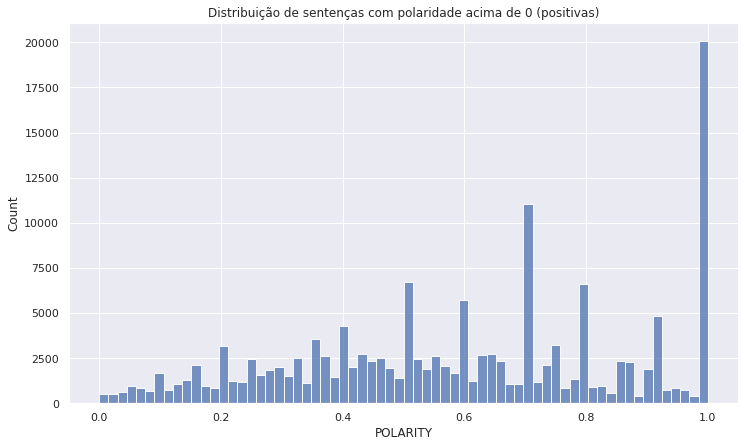

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Distribuição de sentenças com polaridade acima de 0 (positivas)")
sns.histplot(positive_sentences)
plt.show()

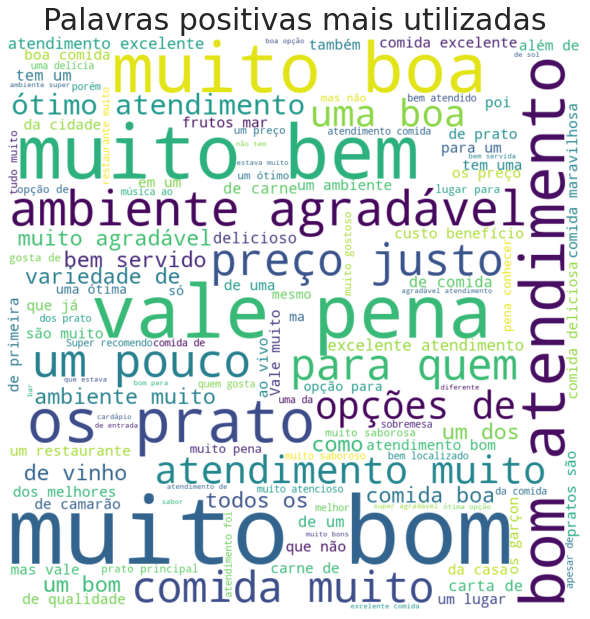

In [ ]:
word_cloud_generator(dft_sentences['BR'].loc[dft_sentences['POLARITY'] > polarity_threshold].astype(str), title="Palavras positivas mais utilizadas")

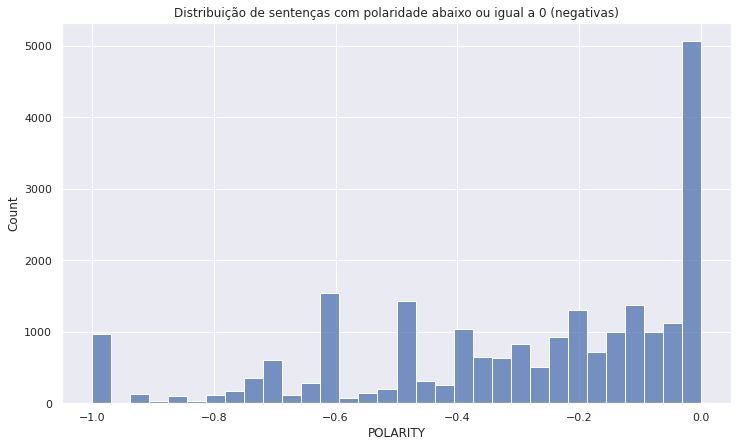

In [ ]:
plt.figure(figsize=(12, 7))
plt.title("Distribuição de sentenças com polaridade abaixo ou igual a 0 (negativas)")
sns.histplot(negative_sentences)
plt.show()

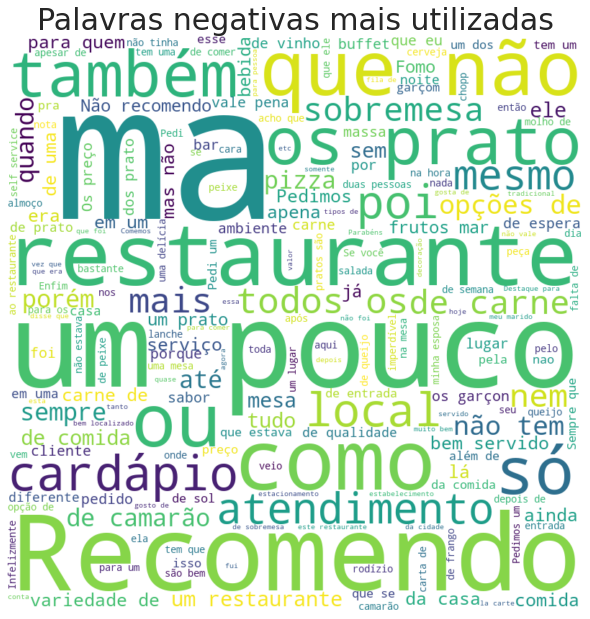

In [ ]:
word_cloud_generator(dft_sentences['BR'].loc[dft_sentences['POLARITY'] <= polarity_threshold].astype(str), title="Palavras negativas mais utilizadas")

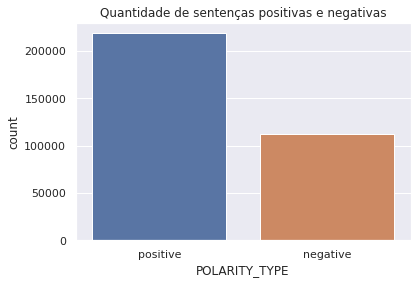

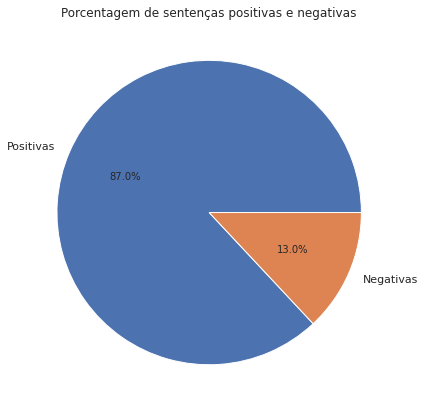

In [ ]:
df_compare = dft_sentences.copy()
df_compare['POLARITY_TYPE'] = ['positive' if data > polarity_threshold else 'negative' for data in dft_sentences['POLARITY']]

plt.title('Quantidade de sentenças positivas e negativas')
sns.countplot(x="POLARITY_TYPE", data=df_compare)
plt.show()

plt.figure(figsize=(8, 7))
plt.title("Porcentagem de sentenças positivas e negativas")
plt.pie(x=[len(positive_sentences), len(negative_sentences)], labels=['Positivas', 'Negativas'], autopct='%1.1f%%')
plt.show()

Para a análise das sentenças positivas e negativas observamos um diferença muito grande entre suas quantidades, ocasiando assim um desbalanceamento no *dataset* para a análise da polaridade, vale observar que as sentenças neutras estão incluídas na parte negativa e mesmo assim tivemos esta alta desproporção. Devido ao grande número de sentenças positivas, podemos então levantar a hipótese de que os usuários não são muito criteriosos e que normalmente atribuem notas altas (acima de 3) para os restaurantes.

---


Gerando um DataFrame de sentenças a partir de um DataSet traduzido com Googletrans

In [ ]:
get_sentences(dfg.sample(n=2))

In [ ]:
dfg_sentences = pd.read_csv("http://underlabs.org/datasets/dfg_sentences.csv")

Obtendo uma amostra de 200 sentenças para Anotação.

Exemplo:

In [ ]:
dfg_sentences[['BR','SUBJECTIVITY', 'POLARITY']].loc[dfg_sentences['BR'] != "!"].sample(n=200).to_csv(index=False)

'BR,SUBJECTIVITY,POLARITY\nRecomendo a dose dupla da jarra de mojitos - sai por um cinquenta e poucos reais serve uns três ou quatro copos.,0.0,0.0\nO ponto alto é a carta de cervejas: mais de 60 cervejas de todo o mundo.,0.5,0.5\nAtendimento excelente de ambos que nos atenderam.Comida muito boa.,0.8000000000000002,0.6\n"O atendimento é de primeira, com garços educados e atenciosos.",0.6166666666666667,0.325\n"Quanto a moqueca da promoção, camarão se achar um você foi premiado, lagosta alguns poucos pedaços pequenos (o famoso catado de lagosta), tomate e cebola a vontade.",0.0,0.0\n"A comida é muito boa, mas o fato de ser self service não me agrada.",0.5,0.5\nTivemos que esperar um pouco pela nossa mesa e nem vimos o tempo passar.,0.0,0.0\ntempero bem mineiro.,0.0,0.0\nViemos almoçar numa quinta-feira e foi uma delícia!,1.0,1.0\n"Lugar bonito e agradável , comida muito boa e bom atendimento.",0.8366666666666668,0.7983333333333333\n"O ambiente é muito agradável, a decoração é muito boni

Anotações


In [ ]:
df_anotacoes = pd.read_csv("http://underlabs.org/datasets/anotacoes.csv", dtype={'reviewId': 'int64', 'SUBJECTIVITY': 'float64','POLARITY': 'float64'}).sort_values(by=['BR']).reset_index(drop=True)

In [ ]:
df_anotacoes.head()

reviewId  ... POLARITY
0  630179894  ...      0.0
1  235139220  ...     -1.0
2  366482456  ...      1.0
3  447213763  ...      1.0
4  412638381  ...      1.0

[5 rows x 4 columns]

In [ ]:
df_anotacoes_csv = df_anotacoes.copy()
df_anotacoes_csv.drop(['reviewId'],axis=1).to_csv('sentencas.csv', index=False)

Como o DataSet já foi completamente traduzido e subjetividade foram calculados pela função `get_sentences`, podemos aproveitar a informação para calcular a métrica dos métodos. Para isso utilizamos dois samples, com as mesmas sentenças anotadas, porém avaliadas pelo TextBlob/Googletrans

In [ ]:
# sample de 200 traduzido pelo textblob
dft_sample = pd.merge(dft_sentences.drop(columns=['US']), df_anotacoes.drop(columns=['SUBJECTIVITY', 'POLARITY']), how='inner', on=['reviewId','BR']).sort_values(by=['BR']).reset_index(drop=True)

In [ ]:
# sample de 200 traduzido pelo googletrans
dfg_sample = pd.merge(dfg_sentences.drop(columns=['US']), df_anotacoes.drop(columns=['SUBJECTIVITY', 'POLARITY']), how='inner', on=['reviewId','BR']).sort_values(by=['BR']).reset_index(drop=True)

A classe SentimentAnalyzesMetrics carrega dois data frames, um produzido pelo método, e outro que serve como gabarito (ground-truth). O Construtor dessa classe possui os seguintes parâmetros:


- `df`: DataFrame com as respostas dadas pelo método
- `dfgt`: DataFrame ground-truth (gabarito)
-`sub_limit`: valor de corte padrão para avaliação da subjetividade
- `pol_limit`: valor de corte padrão para avaliação da polaridade

As métricas são obtidas em formato de dicionário Python, através dos métodos `subjectivity` e `polarity`.

O cálculo das métricas são realizados com base nas fórmulas abaixo:

$Accuracy = \frac{\sum TruePositive + \sum TrueNegative)}{\sum TestDataSize}$

$Precision = \frac{\sum TruePositive}{\sum TruePositive) + \sum FalsePositive}$

$Recall = \frac{\sum TruePositive }{\sum TruePositve) + \sum FalseNegative}$

$F-Measure = \frac{2 \times Precision \times Recall}{Precision + Recall}$


In [ ]:
class SentimentAnalyzesMetrics:

  def __init__(self, df, dfgt, sub_limit=0.5, pol_limit=0):
    self.df = df
    self.dfgt = dfgt
    self.dfm = pd.merge(dfgt, df, on=['reviewId','BR'])
    self.dssize = len(df)
    self.sub = {}
    self.pol = {}
    self._load_data_sub(sub_limit)
    self._load_data_pol(pol_limit)

  def _load_data_sub(self, limit):
    self.sub['y_true'] = self.dfm['SUBJECTIVITY_x'].astype(int)
    self.sub['y_pred'] = self.dfm['SUBJECTIVITY_y'].apply(lambda x:(0,1)[x >= limit])
  
  def _load_data_pol(self, limit):
    # Considering only subjective
    dfpol = self.dfm.loc[self.dfm['SUBJECTIVITY_x'] != 0]
    self.pol['y_true'] = dfpol['POLARITY_x'].astype(int)
    self.pol['y_pred'] = dfpol['POLARITY_y'].apply(lambda x:(-1,1)[x > limit])
  

  def subjectivity(self, metric='report', limit=None):
    if limit:
      self._load_data_sub(limit)
    if metric == 'precision':
      return precision_score(self.sub['y_true'], self.sub['y_pred'])
    elif metric == 'recall':
      return recall_score(self.sub['y_true'], self.sub['y_pred'])
    elif metric == 'f1':
      return f1_score(self.sub['y_true'], self.sub['y_pred'])
    elif metric == 'report':
      print(classification_report(self.sub['y_true'], self.sub['y_pred']))
    else:
      return "metric parameter invalid: use 'precision', 'recall', 'f1' or 'report'"

  def polarity(self, metric='report', limit=None):
    if limit:
      self._load_data_pol(limit)
    if metric == 'precision':
      return precision_score(self.pol['y_true'], self.pol['y_pred'])
    elif metric == 'recall':
      return recall_score(self.pol['y_true'], self.pol['y_pred'])
    elif metric == 'f1':
      return f1_score(self.pol['y_true'], self.pol['y_pred'])
    elif metric == 'report':
      print(classification_report(self.pol['y_true'], self.pol['y_pred']))
    else:
      return "metric parameter invalid: use 'precision', 'recall', 'f1' or 'report'"


  def cm_subjectivity(self, limit=None, ax=None):
    if limit:
      self._load_data_sub(limit)
    cm = confusion_matrix(self.sub['y_true'], self.sub['y_pred'])
    group_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    annot = [f'{l1}\n{l2}\n{l3}' for l1, l2, l3 in zip (group_counts, group_percents, group_labels)]
    annot = np.asarray(annot).reshape(2,2)    
    dfcm = pd.DataFrame(cm,
                        index=['True: Fac', 'True: Sub'],
                        columns=['Pred: Fac', 'Pred: Sub'])
    sns.heatmap(dfcm,fmt='', annot=annot, cmap='Blues', cbar=False, ax=ax)

  def cm_polarity(self, limit=None, ax=None):
    if limit:
      self._load_data_pol(limit)
    cm = confusion_matrix(self.pol['y_true'], self.pol['y_pred'])
    group_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percents = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    annot = [f'{l1}\n{l2}\n{l3}' for l1, l2, l3 in zip (group_counts, group_percents, group_labels)]
    annot = np.asarray(annot).reshape(2,2)    
    dfcm = pd.DataFrame(cm,
                        index=['True: Neg', 'True: Pos'],
                        columns=['Pred: Neg', 'Pred: Pos'])
    sns.heatmap(dfcm,fmt='', annot=annot, cmap='Blues', cbar=False, ax=ax)

  def cm_sub_pol(self):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
    self.cm_subjectivity(ax=ax1)
    self.cm_polarity(ax=ax2)
    plt.subplots_adjust(wspace = 0.5)
    
    plt.show()

#### Avaliando as Métricas

In [ ]:
samtb = SentimentAnalyzesMetrics(dft_sample, df_anotacoes)
samgt = SentimentAnalyzesMetrics(dfg_sample, df_anotacoes)

Métricas:



Precision    Recall  F1 Score
TextBlob      0.847826  0.790541  0.818182
Googletrans   0.846715  0.783784  0.814035



Matriz de Confusão:



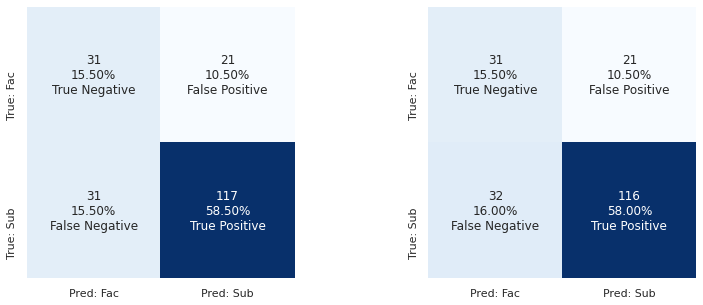

In [ ]:
#@title Subjetividade { run: "auto", vertical-output: true }
sub_limit = 0.39 #@param {type:"slider", min:0, max:1, step:0.01}

sub_dic = {
    'Precision': [samtb.subjectivity('precision',limit=sub_limit),
                  samgt.subjectivity('precision',limit=sub_limit)],
    'Recall': [samtb.subjectivity('recall',limit=sub_limit),
               samgt.subjectivity('recall',limit=sub_limit)],
    'F1 Score': [samtb.subjectivity('f1',limit=sub_limit),
               samgt.subjectivity('f1',limit=sub_limit)],
}

print("Métricas:\n")

pd.DataFrame(sub_dic, index=['TextBlob', 'Googletrans'])
print("\n")

print("Matriz de Confusão:\n")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
samtb.cm_subjectivity(ax=ax1)
samgt.cm_subjectivity(ax=ax2)
plt.subplots_adjust(wspace = 0.5)
plt.show()

Métricas:



Precision    Recall  F1 Score
TextBlob      0.929204  0.826772  0.875000
Googletrans   0.929825  0.834646  0.879668



Matriz de Confusão:



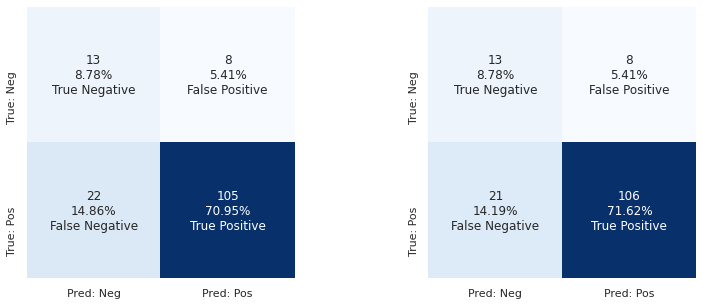

In [ ]:
#@title Polaridade { run: "auto", vertical-output: true }
pol_limit = 0.14 #@param {type:"slider", min:-1, max:1, step:0.01}

pol_dic = {
    'Precision': [samtb.polarity('precision',limit=pol_limit),
                  samgt.polarity('precision',limit=pol_limit)],
    'Recall': [samtb.polarity('recall',limit=pol_limit),
               samgt.polarity('recall',limit=pol_limit)],
    'F1 Score': [samtb.polarity('f1',limit=pol_limit),
               samgt.polarity('f1',limit=pol_limit)],
}

print("Métricas:\n")

pd.DataFrame(pol_dic, index=['TextBlob', 'Googletrans'])
print("\n")

print("Matriz de Confusão:\n")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
samtb.cm_polarity(ax=ax1)
samgt.cm_polarity(ax=ax2)
plt.subplots_adjust(wspace = 0.5)
plt.show()

### Questão 1 - Resolução

Após aplicar os métodos de análise de sentimento nas sentenças dos comentários traduzidos pelo **Googletrans** observamos que embora exista uma variação entre as traduções e as métricas calculadas com relação ao **Textblob**, ela é muito pequena, e de forma geral não altera as métricas de forma significativa.

É possível que a razão dessa diferença tão pequena se dê pelo fato de o **TextBlob** também utilizar uma api do Google, assim como o **Googletrans**, porém uma versão diferente.

## Visão Temporal

Nesta seção o *dataset* será analisado com uma visão temporal, onde será estudado seu comportamento ao longo do tempo.

Assim, o foco principal serão nas colunas ```publicationDate``` e ```visitDate```, que possuem informações temporais de cada registro.

In [ ]:
dfTemporal = df.copy()

dfTemporal.head()

title  ...                                       itemReviewed
0                               Jantar   ...  {'name': 'Imperador dos Camarões', 'address': ...
1                  Uma boa experiência.  ...  {'name': 'Guacamole Natal', 'address': {'stree...
2                    Otimo self service  ...  {'name': 'Chica Pitanga', 'address': {'streetA...
3  O sorvete mais tradicional do estado  ...  {'name': 'Sorvetes Vi Sabor', 'address': {'str...
4                     Melhor hamburger!  ...  {'name': 'Z Deli Sandwich Shop', 'address': {'...

[5 rows x 12 columns]

### Visão Temporal da Data de Publicação

Primeiramente é necessário transformar a coluna ```publicationDate``` no tipo ```datetime``` para que seja possível extrair facilmente as informações de dia, mês e ano. Além disso, foi criado uma coluna extra para obter o dia da semana de cada data.


In [ ]:
dfTemporal['publicationDate'] = pd.to_datetime(dfTemporal['publicationDate'], format = '%d/%m/%Y')

daysOfWeek = ['segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 'domingo']
daysOfWeekMapper = {0:'segunda', 1:'terca', 2:'quarta', 3:'quinta', 4:'sexta', 5:'sabado', 6:'domingo'}

months = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
monthsMapper = {1: 'janeiro', 2: 'fevereiro', 3: 'março', 4: 'abril', 5: 'maio', 6: 'junho',
               7: 'julho', 8: 'agosto', 9: 'setembro', 10: 'outubro', 11: 'novembro', 12: 'dezembro'}

# Criando novas colunas para analisar
dfTemporal['publicationDayOfWeek'] = dfTemporal.publicationDate.dt.dayofweek.map(daysOfWeekMapper)
dfTemporal['publicationDayOfWeek'] = pd.Categorical(dfTemporal['publicationDayOfWeek'], categories=daysOfWeek, ordered=True)

dfTemporal['publicationDay'] = dfTemporal.publicationDate.dt.day

dfTemporal['publicationMonth'] = dfTemporal.publicationDate.dt.month.map(monthsMapper)
dfTemporal['publicationMonth'] = pd.Categorical(dfTemporal['publicationMonth'], categories=months, ordered=True)

dfTemporal['publicationYear'] = dfTemporal.publicationDate.dt.year

In [ ]:
dfTemporal.head()

title  ...  publicationYear
0                               Jantar   ...             2019
1                  Uma boa experiência.  ...             2014
2                    Otimo self service  ...             2019
3  O sorvete mais tradicional do estado  ...             2016
4                     Melhor hamburger!  ...             2015

[5 rows x 16 columns]

In [ ]:
def count_plot(data, x, order=[], title='', figsize=(12, 7)):
  plt.figure(figsize=figsize)
  plt.title(title)
  if order:
    sns.countplot(x=x, data=data, order=order)
  else:
    sns.countplot(x=x, data=data)
  plt.show()

def bar_plot(data, x, y, title='', figsize=(12, 7)):
  plt.figure(figsize=figsize)
  plt.title(title)
  sns.barplot(x=x, y=y, data=data, ci=None)
  plt.show()

def scatter_plot(data, x, y, title='', figsize=(12, 7)):
  plt.figure(figsize=figsize)
  plt.title(title)
  sns.scatterplot(data=data, x=x, y=y)
  plt.show()

Primeiramente, analisou-se quantas postagens foram realizados por ano, no período de 2009 a 2020. Observamos então que o gráfico apresenta uma distribuição crescente até o ano de 2016, chegando ao seu pico com um total de 22056 registros e em seguida apresenta uma distribuição decrescente até o seu fim.

É importante observar que os anos de 2009 e 2010 não apareceram no gráfico por apresentarem valores de 9 e 11, respectivamente. Para esta situação podemos levantar a hipótese de que o site ainda não era muito difundido no Brasil.


Abaixo temos a média de nota para cada ano, onde observamos que a média de cada nota converge para um valor um pouco acima de 4. O ano de 2010 apresenta o maior valor com 4.36, mas conforme dito anteriormente existem apenas 11 registros deste ano, isto consequentemente influenciou em seu valor ser o maior pois existem poucos valores para serem utilizado no cálculo.

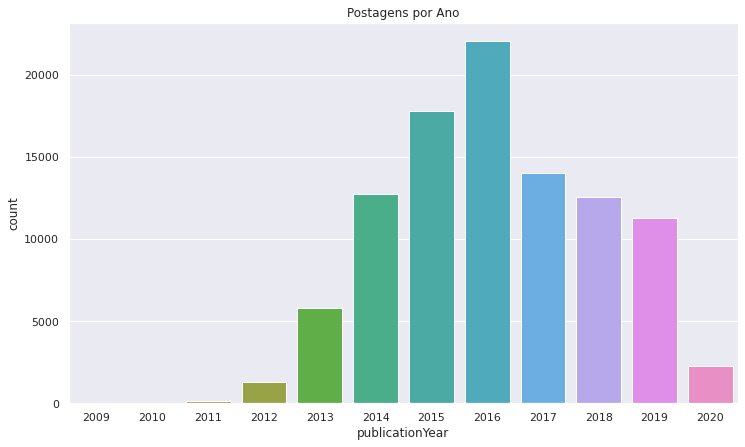

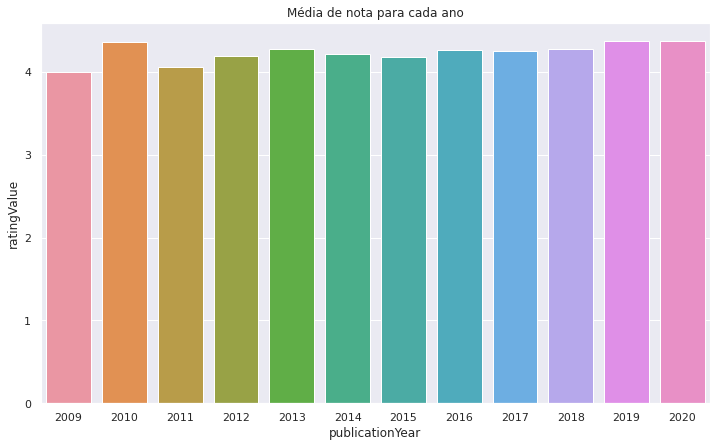

In [ ]:
years = list(dfTemporal.publicationYear.unique())
years.sort()

count_plot(dfTemporal, "publicationYear", years, 'Postagens por Ano')

bar_plot(dfTemporal, "publicationYear", "ratingValue", "Média de nota para cada ano")

Para os meses foi utilizado uma abordagem considerando todos os anos, ou seja, cada mês representa o somatório de registros ao longo do intervalo de anos estabelecido. Podemos observar que o mês apresentou o maior número de postagens ao longo dos anos, com um total de 9933 postagens. Todos os outros meses apresentam dados satisfatórios com todos passando de 6000 postagens, mostrando que o site é bastante movimentado em todos os meses. O mês de Junho apresenta um menor valor dentre todos, com um total de 7037 postagens.

No segundo gráfico, observamos que as médias de notas de cada mês apresentaram valores quase idênticos, mas o mês de agosto apresentou uma média um pouco acima das demais, obtendo 4.29. O único mês que apresenta um valor visivelmente abaixo dos demais é Dezembro, e assim podemos levantar a hipótese de que as pessoas um pouco mais criteriosas publicaram suas *reviews* neste mês.


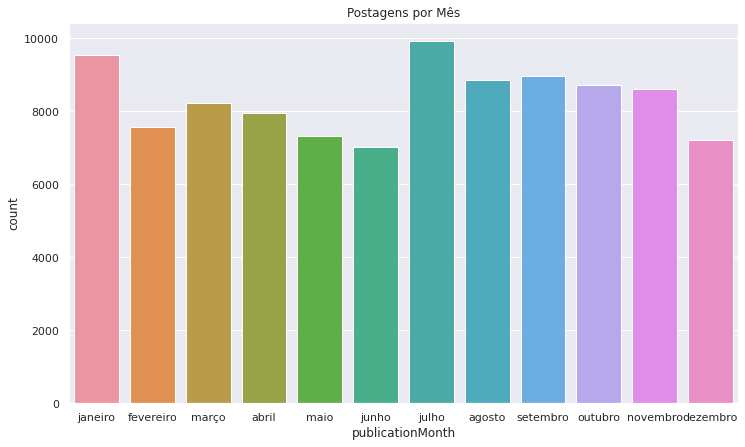

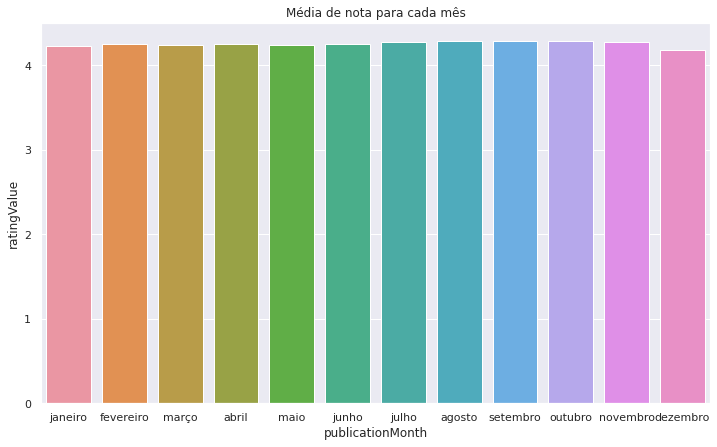

In [ ]:
dfTemporalOrdered = dfTemporal.sort_values('publicationMonth')

count_plot(dfTemporalOrdered, "publicationMonth", months, 'Postagens por Mês')

bar_plot(dfTemporalOrdered, "publicationMonth", "ratingValue", "Média de nota para cada mês")

Para a análise dos dias, seguimos a mesma estratégia abordada para os meses. Dois dias se destacam por serem os únicos a apresentar um total de postagens maior que 3500, onde o dia 26 apresenta 3655 postagens e o dia 28 acumula 3697, sendo assim o dia com o maior pico. O dia 31 exibe um valor bem menor comparado aos outros dias, totalizando apenas 1990 postagens, a principal hipótese para este acontecimento se desse ao fato de alguns meses não possuem o dia 31.

Assim como ocorreu com os meses, os dias apresentam uma distribuição quase homogênea de sua média de notas, o dia 6 apresenta uma pequena vantagem em relação aos outros com uma média de 4.28.

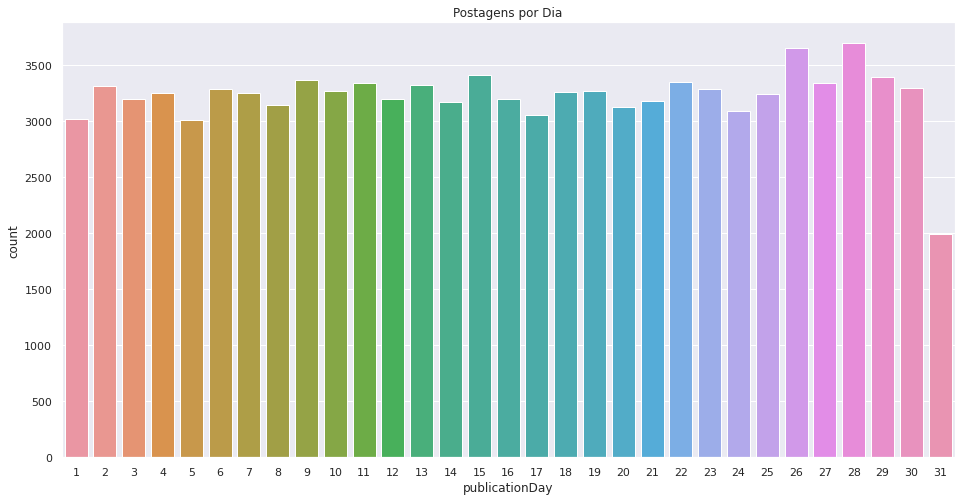

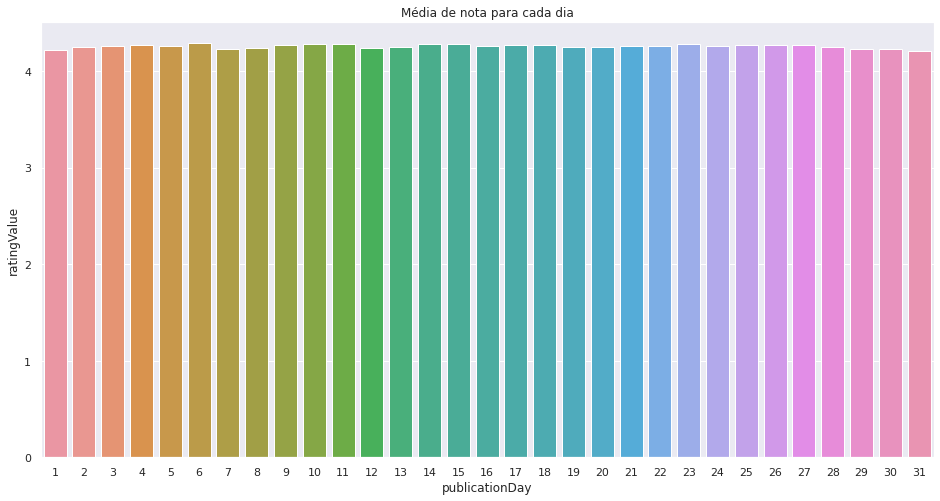

In [ ]:
days = list(dfTemporal.publicationDay.unique())
days.sort()

count_plot(dfTemporal, "publicationDay", days, 'Postagens por Dia', (16, 8))

bar_plot(dfTemporal, "publicationDay", "ratingValue", "Média de nota para cada dia", (16, 8))

Por fim, analisou-se o comportamento dos dias da semana ao longos dos anos, podemos observar que terça e quarta possuem valores extremamentes idênticos, apresentando 15747 e 15727, respectivamente. Assim, na terça-feira ocorre o maior número de postagens e sexta-feira apresenta o menor número.

Novamente a média de notas apresentou uma distribuição similar para todos os dias da semana, com uma leve vantagem para terça-feira com um total de 4.29.

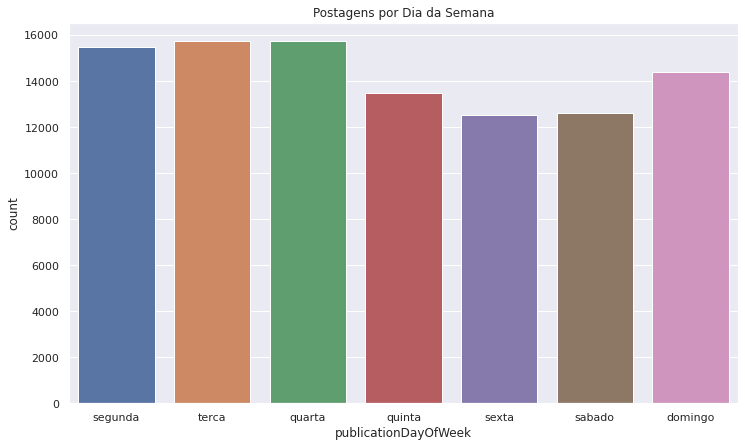

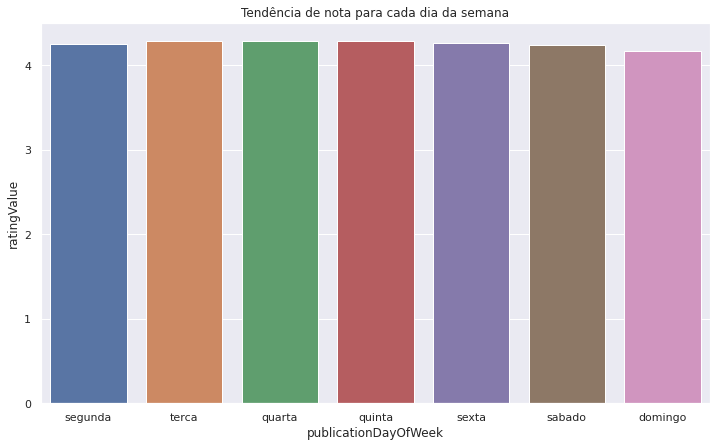

In [ ]:
dfTemporalOrdered = dfTemporal.sort_values('publicationDayOfWeek')

count_plot(dfTemporalOrdered, "publicationDayOfWeek", daysOfWeek, 'Postagens por Dia da Semana')

bar_plot(dfTemporalOrdered, "publicationDayOfWeek", "ratingValue", "Tendência de nota para cada dia da semana")

Após a analisar a média de nota das postagens para cada visão apresentada, podemos chegar a algumas hipóteses à respeito do *dataset*:

* As pessoas não são muito criteriosas, pois suas avaliações apresenta uma média próxima de 4.
* Os registros estão desbalanceados, com foco maior em avaliações positivas e consequentemente tendo médias altas.

### Visão Temporal da Data de Visita

Toda a análise feita acima foi focada na coluna ```publicationDate```, a data que a postagem foi publicada. É interessante também analisarmos a coluna ```visitDate```, que contém a informação a respeito de quando o usuário visitou o restaurante.

Inicialmente identificamos que esta coluna possui apenas mês e ano, e que apresenta registros com valores "None", ou seja, não foi informado quando a data de visita. Para facilitar a análise, decidiu-se extrair todos os registros que possuem este valor, removendo-se assim 4330 linhas do *dataset*.

In [ ]:
dfTemporalVisited = dfTemporal.copy()

# Removendo linhas que possuem 'None' como data de visita, pois não será interessante analisá-los

dfTemporalVisited.drop(dfTemporalVisited[dfTemporalVisited.visitDate == 'None'].index, inplace=True)

print(f'Quantidade de linhas que possuem None como Data de Visita: {len(dfTemporal) - len(dfTemporalVisited)}')

Quantidade de linhas que possuem None como Data de Visita: 4330


Novamente criamos duas colunas para facilitar a extração do ano e mês de cada data.

In [ ]:
dfTemporalVisited['visitDate'] = pd.to_datetime(dfTemporalVisited['visitDate'], format = '%m/%Y')

months = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
monthsMapper = {1: 'janeiro', 2: 'fevereiro', 3: 'março', 4: 'abril', 5: 'maio', 6: 'junho',
               7: 'julho', 8: 'agosto', 9: 'setembro', 10: 'outubro', 11: 'novembro', 12: 'dezembro'}

# Criando novas colunas para analisar

dfTemporalVisited['visitYear'] = dfTemporalVisited.visitDate.dt.year

dfTemporalVisited['visitMonth'] = dfTemporalVisited.visitDate.dt.month.map(monthsMapper)
dfTemporalVisited['visitMonth'] = pd.Categorical(dfTemporalVisited['publicationMonth'], categories=months, ordered=True)

Primeiramente analisamos as datas de visitas ao longo dos anos, percebe-se de imediato que este gráfico também apresenta uma distribuição crescente até o ano de 2016, com seu pico em 20080 registros e então com uma distribuição decrescente até o seu fim. Este mesmo comportamento se repete para o gráfico de "Postagens por Ano", podemos então levantar a hipótese que as pessoas costumam postar no site no mesmo ano que visitam o restaurante.

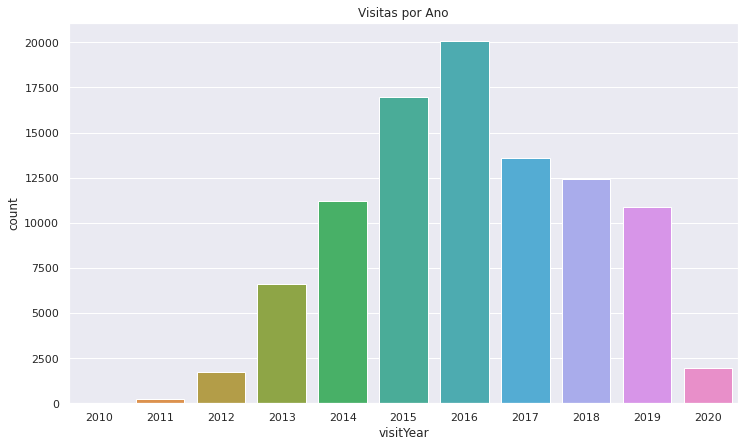

In [ ]:
years = list(dfTemporalVisited.visitYear.unique())
years.sort()

count_plot(dfTemporalVisited, "visitYear", years, 'Visitas por Ano')

Analisou-se também as datas de visita dos meses ao longo do anos, e novamente repetiu-se o comportamento observado no "Postagens por Mês" e consequentemente permitindo levantar a hipótese que além das pessoas terem o costume de postar no site no mesmo ano que visitaram o restaurante, também costumam postar no mesmo mês da visita.

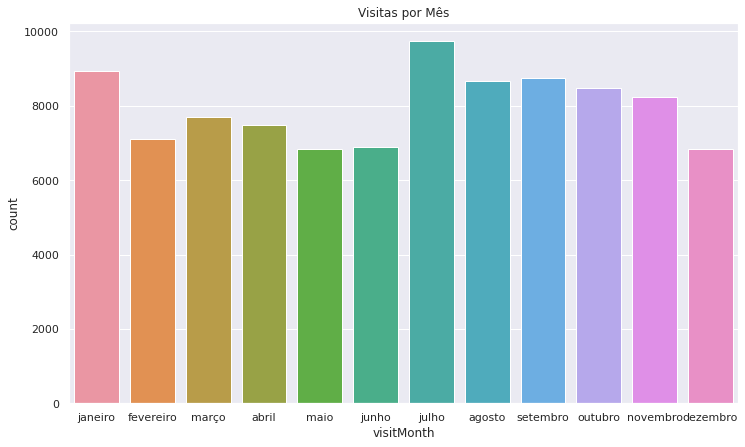

In [ ]:
dfTemporalVisitedOrdered = dfTemporalVisited.sort_values('visitMonth')

count_plot(dfTemporalVisitedOrdered, "visitMonth", months, 'Visitas por Mês')

Além de analisar as duas colunas, é interessante observar se existem situações em que a pessoa publicou a *review* no mesmo dia que ela visitou o restaurante, e caso tenha, entender se essas pessoas possivelmente postaram no local do restaurante (através do celular) ou se esperam pra chegar em casa para postar.

In [ ]:
dfTemporalVisited['compareDate'] = dfTemporalVisited.publicationDate == dfTemporalVisited.visitDate

In [ ]:
dfTemporalVisited.head()

title   reviewId  ...  visitMonth compareDate
0                               Jantar   692856288  ...       julho       False
2                    Otimo self service  679002332  ...       junho       False
3  O sorvete mais tradicional do estado  355671519  ...       março       False
4                     Melhor hamburger!  268741921  ...       abril       False
5                Um achado maravilhoso!  482361860  ...        maio       False

[5 rows x 19 columns]

O gráfico abaixo apresenta uma comparação de postagens feitas no dia da visita, *False* caso ele não postou no dia e *True* se foi postado no dia, aproveitou-se também para verificar se a postagem foi publicada no celular ou não. Observamos então que quase todas as pessoas não costumam publicar a análise no dia da visita, mas normalmente é no mesmo mês e ano, conforme foi analisado acima.

Apenas um total de 1004 pessoas publicaram no mesmo dia, e devido ao baixo número de pessoas nesta categoria, ficou um pouco difícil visualizá-la, assim precisou-se de um gráfico adicional.

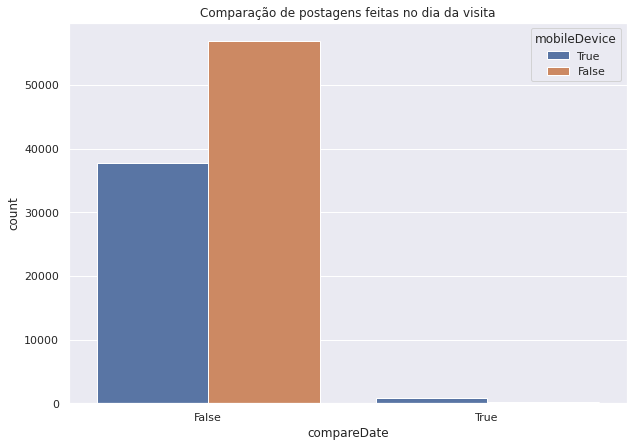

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(x="compareDate", hue="mobileDevice", data=dfTemporalVisited)
plt.title("Comparação de postagens feitas no dia da visita")
plt.show()

Por fim, temos uma análise mais detalhada das postagens publicadas no dia, para levantarmos a hipótese de que essas pessoas realizam a publicação dentro do restaurante, através do celular. Observamos então que dentre os 1004 registros extraídos, 80.6% são de pessoas que publicam pelo celular e apenas 19.4% não publicam.

Não temos mais informações para levar esta hipótese adiante, mas já podemos fazer a suposição de esses 809 usuários, que representam 80.6%, podem ter publicados suas análises dentro do restaurante após consumir suas refeições, e o restante, 195, publicou após chegar em casa.

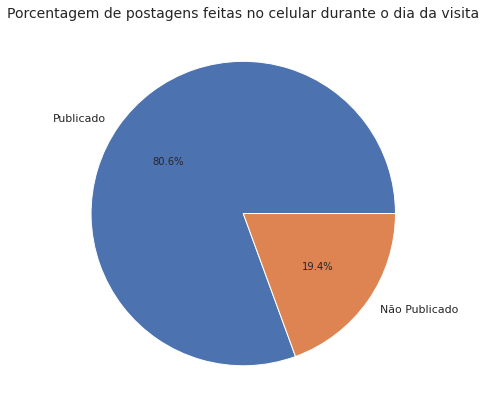

In [ ]:
warnings.filterwarnings('ignore')

size = len(dfTemporalVisited[dfTemporalVisited.compareDate])
isMobileDevice = len(dfTemporalVisited[(dfTemporalVisited.compareDate == True) & (dfTemporal.mobileDevice == 'True')])
isNotMobileDevice = len(dfTemporalVisited[(dfTemporalVisited.compareDate == True) & (dfTemporal.mobileDevice == 'False')])

plt.figure(figsize=(10, 7))
plt.title('Porcentagem de postagens feitas no celular durante o dia da visita', {'fontsize': 14})
plt.pie(x = [isMobileDevice, isNotMobileDevice], labels = ['Publicado', 'Não Publicado'], autopct='%1.1f%%')
plt.show()

## Visão Geográfica

Existe apenas um campo que contém informações a respeito da localização geográfica, que é o `userLocation`, mas esta coluna não segue um padrão de escrita que ocasiona um aparecimento de palavras repetidas escritas de maneira diferente, ex.: São Paulo, SÃO PAULO, sao paulo, SP. Como isto dificulta a análise, primeiramente será realizado um pré-processamento desses dados para agrupar estas cidades repetidas e assim ter apenas uma única cidade.


Após isso ainda teremos um alto número de cidades distintas e seria inviável exibir todas em um único gráfico, assim é interessante obter informações a respeito da latitude e longitude das cidades, para exibí-las em um gráfico estilo mapa.

In [8]:
!pip install geopandas

In [9]:
!pip install unidecode
!pip install Unidecode

In [10]:
import geopandas
from geopy.geocoders import Nominatim
from collections import Counter, defaultdict
import copy
from difflib import SequenceMatcher
import unidecode
from random import randint

import folium
from IPython.display import display

Inicialmente será desenvolvido um algoritmo capaz de agrupar cidades repetidas, mas como os textos não seguem nenhum tipo de padrão, existem alguns que são extremamente difíceis em código genérico. Assim, para facilitar este processo, algumas palavras foram atualizados manualmente, além de também remover valores que não são interessantes de serem analisados.

In [ ]:
dfLocation = df.copy()

# removendo linhas de lugares inexistentes
dfLocation.drop(dfLocation[dfLocation.userLocation == 'None'].index, inplace = True)
dfLocation.drop(dfLocation[dfLocation.userLocation == 'São'].index, inplace = True)
dfLocation.drop(dfLocation[dfLocation.userLocation == 'Santa Bárbara d&amp;#39;Oeste, Brasil'].index, inplace = True)

# Alguns lugares são tão específicos que fica difícil analisá-los de forma geral, portanto ocorre a necessidade de alterá-los manualmente
dfLocation.userLocation = dfLocation.userLocation.replace(['SSA', 'Ssa'], 'Salvador, Bahia')
dfLocation.userLocation = dfLocation.userLocation.replace(['Ji-Paraná'], 'Ji-Paraná, RO')
dfLocation.userLocation = dfLocation.userLocation.replace(['Bragança Paulista', 'Braganca Paulista, Brazil'], 'Bragança Paulista, SP')
dfLocation.userLocation = dfLocation.userLocation.replace(['POa', 'Poa'], 'Porto Alegre, RS')
dfLocation.userLocation = dfLocation.userLocation.replace(['Poá, SP', 'Poá'], 'Poá, SP')
dfLocation.userLocation = dfLocation.userLocation.replace(['BH', 'bh', 'BH, Brasil'], 'Belo Horizonte, MG')
dfLocation.userLocation = dfLocation.userLocation.replace(['Bauru, null, Democratic Republic of the Congo'], 'Bauru, Democratic Republic of the Congo')
dfLocation.userLocation = dfLocation.userLocation.replace(['SP', 'sp', 'Sp', 'Estado de São Paulo'], 'São Paulo, SP')
dfLocation.userLocation = dfLocation.userLocation.replace(['BRASIL', 'BRAZIL', 'Brazil', 'brasil'], 'Brasil')
dfLocation.userLocation = dfLocation.userLocation.replace(['Rio de Janeiro - Brazil', 'Rio de Janeiro'], 'Rio de Janeiro, RJ')
dfLocation.userLocation = dfLocation.userLocation.replace(['Manaus ,AMAZONAS, BRASIL'], 'Manaus, AM')

A função ```check_city``` é a principal responsável por buscar cidades com nomes repetidos presente no *dataset*, ela recebe como parâmetro um dicionário de cidades onde cada possui como valor uma lista da mesma cidade com outro nome, e como segundo parâmetro uma nova cidade para avaliá-la.

É feito uma iteração no dicionário para tentar identificar se esta nova cidade já existe, primeiramente todo o texto fica em caixa baixa e é removido qualquer tipo de acento para facilitar a comparação. A ideia principal é verificar se a nova cidade possui o texto similar à cidade já catalogada, ou seja, se é uma *substring*, inseriu-se também uma segunda verificação para analisar a similaridade entre o nome das duas cidades, onde só será válido se as palavras estiverem uma similaridade de 80%, este ponto é importante pois existem muitas cidades diferentes com nomes parecidos.


In [ ]:
 def check_city(city_dict, new_city):
  for city in city_counter:

    compare_new_city = unidecode.unidecode(new_city.lower())
    compare_city = unidecode.unidecode(city.lower())

    if ',' in compare_city:
      compare_city = compare_city.split(',')[0]
    
    if ',' in compare_new_city:
      compare_new_city = compare_new_city.split(',')[0]

    if compare_new_city in compare_city:
      if SequenceMatcher(None, compare_new_city, compare_city).ratio() >= 0.8:
        return city
    
  return ""

Primeiramente obtêm-se a lista de cidades presentes no *dataset*, algumas cidades foram removidas para facilitar a execução do algoritmo e não haver problemas adicionais.

In [ ]:
# Algumas cidades podem prejudicar a verificação  de cidades repetidas
cities_to_remove = ['brasil', 'ji-paraná, ro', 'bauru, democratic republic of the congo']
list_unique_cities = dfLocation.userLocation.unique()

list_unique_cities = [city for city in list_unique_cities if city.lower() not in cities_to_remove]

Assim, a lista de cidades é percorrida e para cada cidade é utilizado a função ```check_city````para identificar cidades repetidas e então preencher um dicionário

In [ ]:
city_counter = {}

for city in list_unique_cities:
  city_found = check_city(city_counter, city)

  if city_found != "":
    city_counter[city_found].append(city)
  else:
    city_counter[city] = []


repeated_cities = { city:repeated_cities for city, repeated_cities in city_counter.items() if len(repeated_cities) > 1}

print(repeated_cities)

{'São Carlos, SP': ['São Carlos, São Paulo, Brazil', 'São Carlos, SC', 'São Carlos'], 'Manaus, AM': ['Manaus', 'MANAUS', 'manaus', 'Manaus, Amazonas, Brazil', 'Manaus, Brasil', 'Manaus, Brazil', 'Manaus, Brasil, América do Sul'], 'Goiânia, GO': ['Goiânia, Goias, Brazil', 'Goiânia', 'Goiania, Brazil', 'Goiania, Go', 'Goiania', 'goiania', 'Goiânia, Brasil', 'Goiânia, Go', 'Goiania, GO', 'Goiânia, Goiás'], 'Aracaju, SE': ['ARACAJU', 'Aracaju', 'Aracaju, Brasil', 'aracaju', 'Aracaju, Brazil', 'Aracaju, Sergipe, Brazil'], 'Rio de Janeiro, RJ': ['rio de janeiro', 'Rio de Janeiro, Rio de Janeiro, Brazil', 'Rio de Janeiro, Brazil', 'Rio de Janeiro, Brasil', 'Rio De Janeiro', 'Rio de janeiro', 'RIO DE JANEIRO', 'RIO DE JANEIRO, Brazil', 'Rio De Janeiro, Brazil', 'Rio De Janeiro, Brasil', 'rio de janeiro, Brasil', 'Rio de Jan', 'rio de Janeiro', 'Rio De Janeiro, Rj', 'Río de Janeiro, RJ', 'Rio De Janeiro, Capital', 'rio de janeiro, rio de janeiro'], 'Brasília, DF': ['Brasília, Distrito Federal, 

O dicionário gerado é passado para o DataFrame substituir as cidades repetidas por apenas uma palavra

In [ ]:
for city, change_cities_list in repeated_cities.items():
  dfLocation.userLocation = dfLocation.userLocation.replace(change_cities_list, city)

Para obter a latitude e longitude de cada cidade, é necessário chamar uma função da biblioteca do ```geopy``` que irá se comunicar externamente com as APIs do Google e retornar a cidade. Devido ao alto número de cidades presentes no *dataset*, o algoritmo poderá sofrer problema de *timeout*, ou seja, a API para de responder devido ao alto número de requisições vindas de um mesmo endereço.

Para contornar esta situação é necessário fazer algumas adaptações nos códigos, na função ```geocode```, que é a principal responsável por realizar a aquisição, foi inserido duas validações: caso a requisição apresenta um erro, o algoritmo é colocado para "dormir" (```time.sleep```) em um tempo aleatório e em seguida a requisição é feita novamente, se após 10 tentativas continuar ocorrendo o mesmo problema, o sistema gera uma mensagem de erro, pois isso significa que a biblioteca irá parar de responder por um tempo, sendo necessário aguardar alguns minutos.

In [12]:
def geocode(city, recursion=0, timeout=100, sleep_sec=3):
  try:
    return locator.geocode(city, timeout)
  except Exception as e:
    if recursion > 10:
      print("Error in request for city: ", city)
      raise e
    time.sleep(randint(1 * 100, sleep_sec * 100) / 100)

    return geocode(city, recursion=recursion + 1)

In [13]:
def findCity(listOfCities, city):
  try:
    index = listOfCities.index(city)
    return index
  except ValueError:
    return -1

A variável ```location``` é responsável por guardar todas as latitudes e longitudes que foram catalogadas e todas as cidades que já foram utilizadas para fazer uma requisição, e sua última posição guarda o último índice do DataFrame computado.

In [14]:
location = {'latitude': [], 'longitude': [], 'city': [], 'lastIndex': -1}

O código abaixo é responsável por percorrer todo o *dataset*, extrair a localização do usuário e realizar a requisição para obter sua latitude e longitude, todas as informações são armazenadas na variável acima conforme descrito.

Este código foi otimizado para tentar contornar possíveis problema durante a requisição, para cada cidade é verificado se sua posição já está catalogada, caso esteja apenas buscando as informações necessários e inserimos novamente no dicionário, se não tiver é necessário realizar de fato a requisição. Para cada iteração, o último índice analisado é salvo pois se por algum motivo o código parar de ser executado, é possível continuar do mesmo local que parou pois a variável ```location``` continua salva em memória.

Observamos durante a aquisição dos dados que o código foi capaz de ser executado durante aproximadamente 1 hora até que a API começasse a apresentar problemas obtendo-se mais 50000 cidades catalogadas, assim foi necessário executá-lo apenas outra vez para terminar a iteração no *dataset*.

In [ ]:
user_agent = 'TRIPADVISOR_{}'.format(randint(10000,99999))
locator = Nominatim(user_agent=user_agent, timeout=3)

for index, row in dfLocation.iterrows():

  if index > location['lastIndex']:
    # print("Current Index: ", index)
    city = row.userLocation

    cityIndex = findCity(location['city'], city)

    if cityIndex != -1:
      # print("Repeated city! ", city)
      latitude = location['latitude'][cityIndex]
      longitude = location['longitude'][cityIndex]

      location['latitude'].append(latitude)
      location['longitude'].append(longitude)
    else:
      # print("Processing city: ", city)
      data = geocode(city)

      location['city'].append(city)
      
      if data is not None:
        location['latitude'].append(data.latitude)
        location['longitude'].append(data.longitude)
      else:
        location['latitude'].append(np.nan)
        location['longitude'].append(np.nan)
      
      time.sleep(2)
    location['lastIndex'] = index

In [ ]:
dfLocation['latitude'] = location['latitude']
dfLocation['longitude'] = location['longitude']

Se existir alguma cidade que não foi possível obter sua localização, é necessário removê-la do *dataset* para evitar possíveis problemas.


In [ ]:
# Para alguns lugares não é possível pegar sua latitude e longitude, portanto precisam ser removidos
dfLocation = dfLocation[dfLocation.latitude.notna()]

In [ ]:
#dfLocation.to_csv('df_location.csv', index=False)

Subindo o csv previamente processado para evitar novo processamento:

In [21]:
dfLocation = pd.read_csv('http://underlabs.org/datasets/df_location.csv')

In [22]:
dfLocation.head()

title   reviewId  ...   latitude  longitude
0                               Jantar   692856288  ... -22.018337 -47.890932
1                  Uma boa experiência.  229208487  ...  -3.131633 -59.982504
2                    Otimo self service  679002332  ... -16.680882 -49.253269
3  O sorvete mais tradicional do estado  355671519  ... -10.916206 -37.077466
4                     Melhor hamburger!  268741921  ... -22.911014 -43.209373

[5 rows x 14 columns]

Será utilizado a mesma abordagem aplicada na visão temporal, onde criamos novas colunas para ajudar a extrair informações sobre data, mês e ano

In [23]:
dayOfWeek = {0:'segunda', 1:'terca', 2:'quarta', 3:'quinta', 4:'sexta', 5:'sabado', 6:'domingo'}
dfLocation['publicationDate'] = pd.to_datetime(dfLocation['publicationDate'], format = '%d/%m/%Y')

# Criando novas colunas para analisar

dfLocation['publicationDayOfWeek'] = dfLocation.publicationDate.dt.dayofweek.map(dayOfWeek)
dfLocation['publicationDay'] = dfLocation.publicationDate.dt.day
dfLocation['publicationMonth'] = dfLocation.publicationDate.dt.month
dfLocation['publicationYear'] = dfLocation.publicationDate.dt.year

In [51]:
locator = Nominatim(user_agent=user_agent, timeout=3)

center = locator.geocode('Brasil')

In [52]:
def display_map(df, title, mapType, year=None, rating=None, save=False):
  title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)
  
  ## tiles = cartodbpositron or openstreetmap
  # f = folium.Figure(width=1500, height=600)
  # map = folium.Map(location=[center.latitude, center.longitude], tiles="openstreetmap", zoom_start=3).add_to(f)

  map = folium.Map(
      location=[center.latitude, center.longitude],
      tiles='openstreetmap',
      zoom_start=3,
  )

  map.get_root().html.add_child(folium.Element(title_html))

  if mapType == 'date':
    dfDate = df[df.publicationDate.dt.year == year]
    dfDate.apply(lambda row: folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=2).add_to(map), axis=1)

  if mapType == 'rating':
    dfRating = df[df.ratingValue == rating]
    dfRating.apply(lambda row: folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=2).add_to(map), axis=1)

  if save:
    map_name = title + '.html'
    print(f'Saving file: {map_name}')
    map.save(map_name)
  else:
    display(map)

In [26]:
def get_color(rating):
  rating = int(rating)
  print(rating)
  if rating == 5:
    return 'black'
  elif rating == 4:
    return 'blue'
  elif rating == 3:
    return 'green'
  elif rating == 2:
    return 'yellow'
  elif rating == 1:
    print('entrou aqui')
    return 'red'

In [57]:
display_map(dfLocation, 'Distribuicao Geografica para Avaliacao igual a 1', 'rating', rating=1)

In [59]:
display_map(dfLocation, 'Distribuicao Geografica para Avaliacao igual a 5', mapType='rating', rating=5)

In [60]:
display_map(dfLocation, 'Distribuicao Geografica de Publicacoes no Ano de 2012', 'date', 2012)

In [61]:
display_map(dfLocation, 'Distribuicao Geografica de Publicacoes no Ano de 2020', 'date', 2020)